# **1) EXPLORATIVE DATA ANALYSIS**

---


In [ ]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg
!pip install transformers
!pip install datasets
!pip install evaluate

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns
import matplotlib.colors as mcolors

# Pre-processing
import spacy
from spacy.lang.it import Italian
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary
from multiprocessing import cpu_count
import gensim.downloader as api

# Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Models and utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
import evaluate
from sklearn.metrics import accuracy_score

# Pytorch library for neural network
import torch
from torch import nn, optim
import torch.nn.functional as F
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is: ', str(device).upper())
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
import torchvision.transforms as transforms

# HugginFace Utils
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

from transformers import BertTokenizer, BertModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albertogvalerio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Device is:  MPS


In [2]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt',
    'haspeede2_reference_taskAB-tweets.csv',

    # Testing task 2 with labels
    'hate_test_gold_standards.csv'
]

In [3]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

task_2_standard = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])

In [4]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [5]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [6]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


In [7]:
task_2_standard.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,5000.jpg,41,0,0,ogni singolo pensiero di salvini,1
1,5001.jpg,7,1,Salvini,per un nuovo governo: facile.it governare è fa...,0
2,5002.jpg,22,0,Lega,la lega a roma? e poi sarei io er monnezza! er...,1
3,5003.jpg,137,1,Conte,internazionale può funzionare un'alleanza tra ...,0
4,5004.jpg,2667,0,PD,esempi di cose che si autodistruggono,1


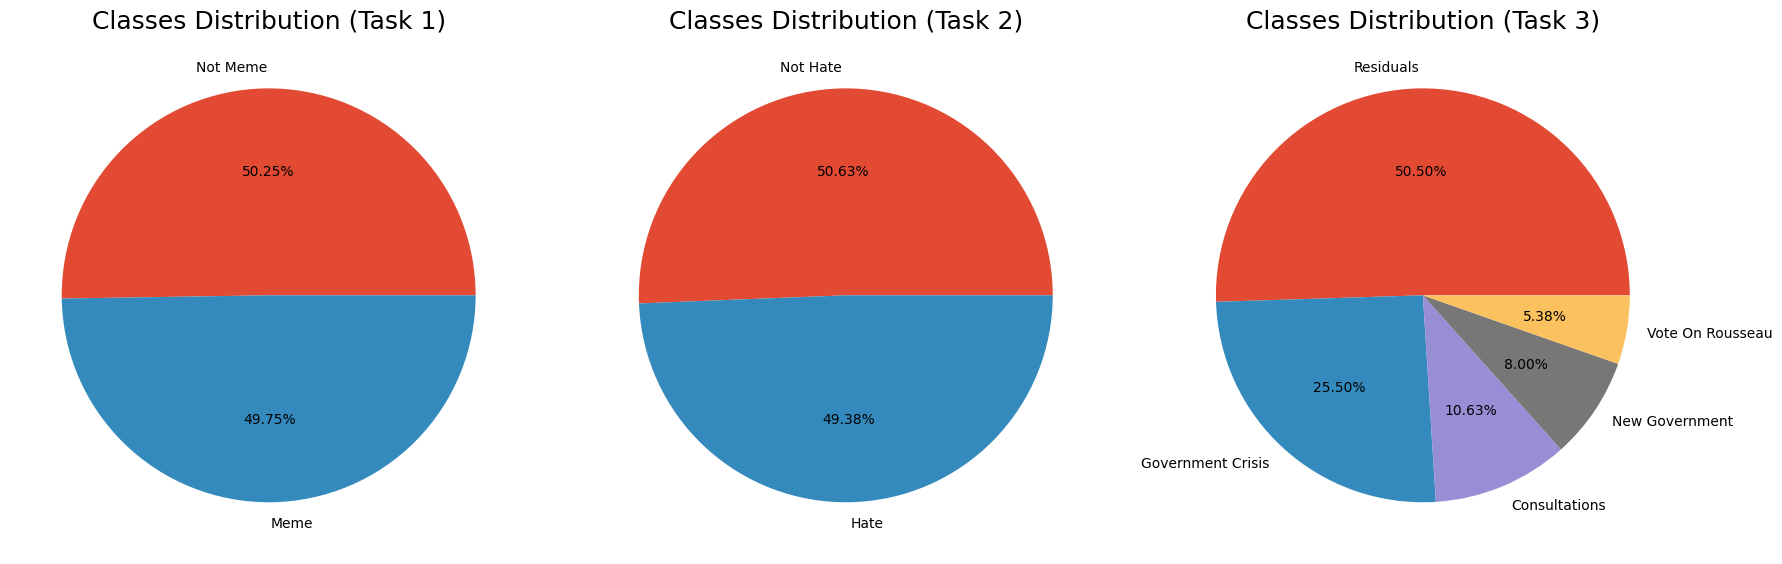

In [221]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

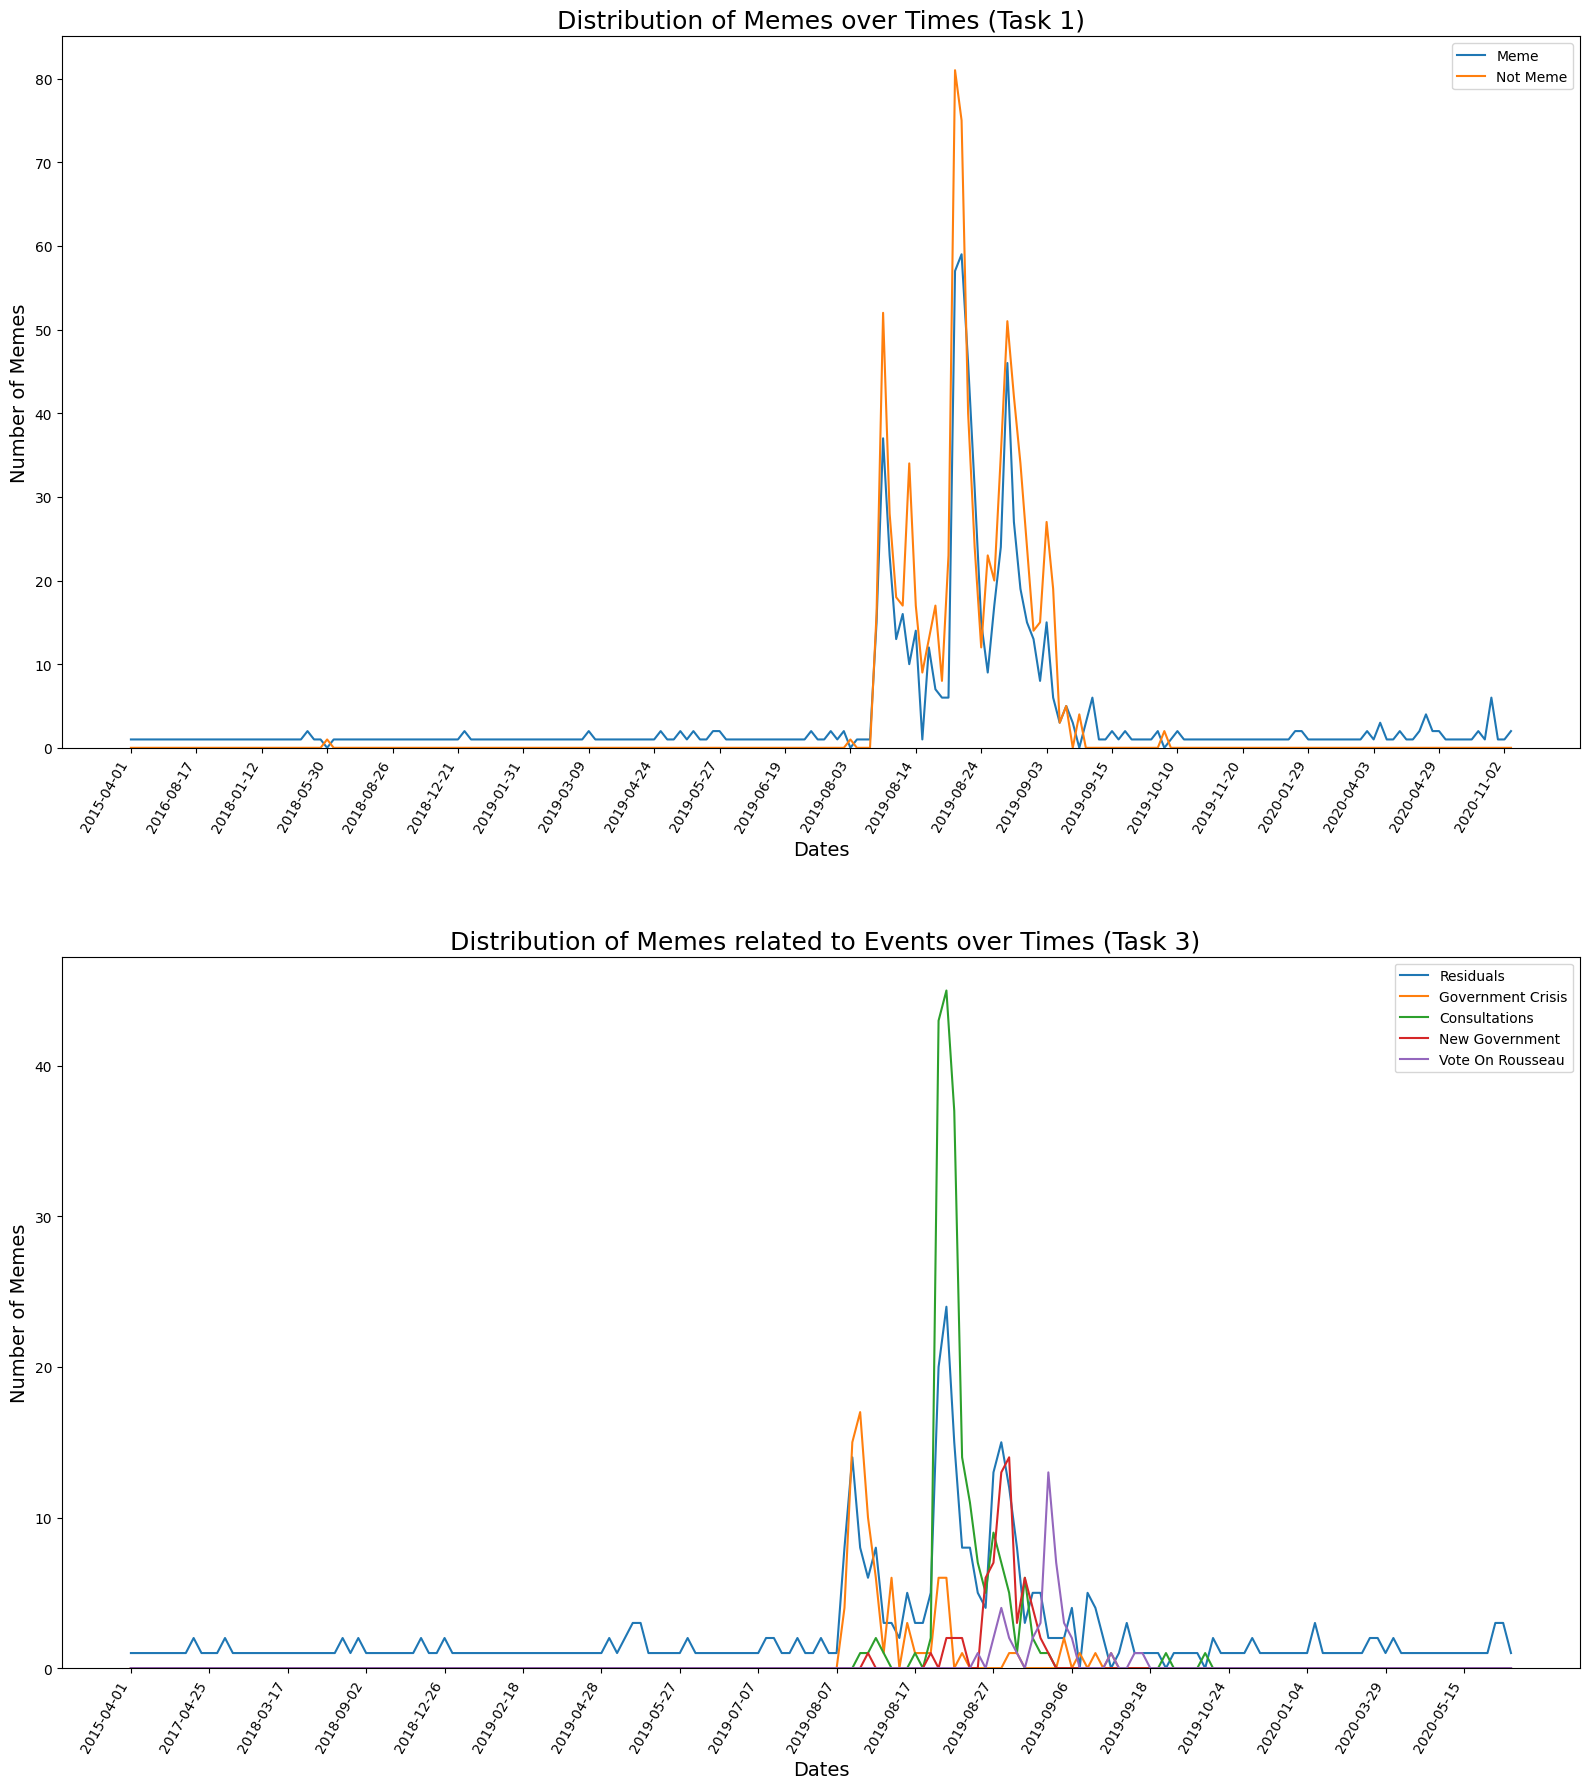

In [ ]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

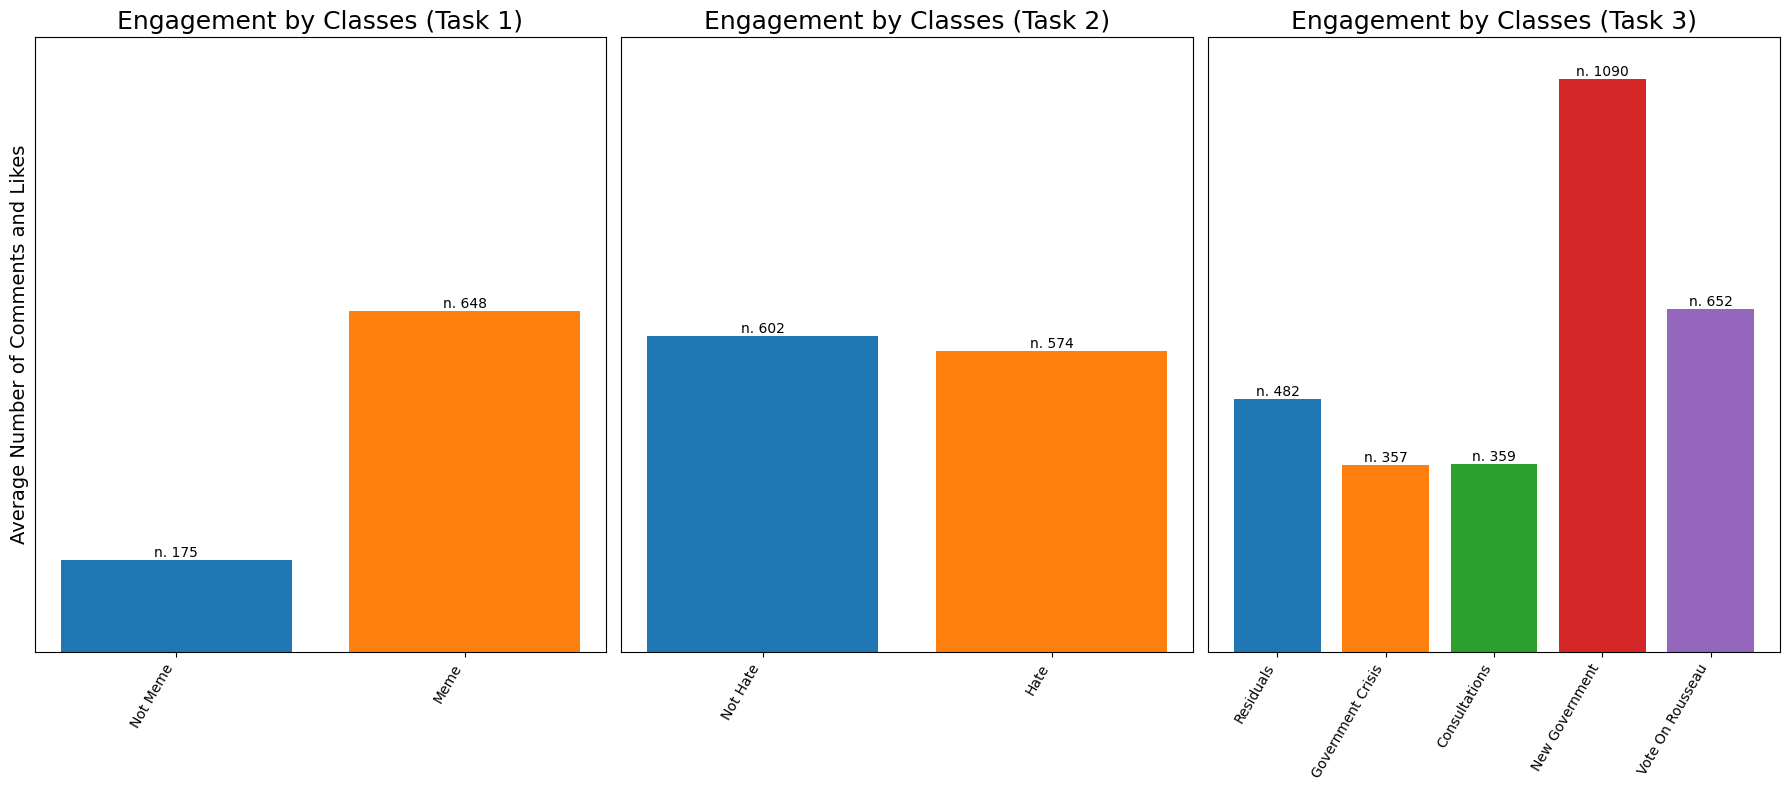

In [ ]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

# **2) PRE-PROCESSING**

---


In [5]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [6]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [7]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [10]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           "che è successo" "me so rotto er cazzo" leonardo sciascia opere adelphi piazza grande mezzogiorno
PROCESSED:          ['successo', 'rompere', 'cazzo', 'leonardo', 'sciascia', 'opere', 'adelphi', 'piazza', 'grande', 'mezzogiorno']
NO_LEMMATIZATION:   ['successo', 'rotto', 'cazzo', 'leonardo', 'sciascia', 'opere', 'adelphi', 'piazza', 'grande', 'mezzogiorno']


ORIGINAL:           quando ho chiesto un "toscano" mi riferivo a un sigaro non ad un cazzaro. renzi sbarca a cuba
PROCESSED:          ['quando', 'chiedere', 'toscano', 'riferivo', 'sigaro', 'cazzaro', 'renzi', 'sbarcare', 'cuba']
NO_LEMMATIZATION:   ['quando', 'chiesto', 'toscano', 'riferivo', 'sigaro', 'cazzaro', 'renzi', 'sbarca', 'cuba']


ORIGINAL:           male, female, white, black, rich, poor, gay, straight, elettore medio di salvini
PROCESSED:          ['male', 'female', 'white', 'black', 'rich', 'poor', 'gay', 'straight', 'elettore', 'medio', 'salvini']
NO_LEMMATIZATION:   ['male', 'female', 'white', 

# **3) FEATURES EXTRACTION**

---


In [4]:
data = task_2_train

## **Text Processed**

In [13]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
436,1436.jpg,28,0,Salvini,"""che posso parla' da l' banco?""",potere parlare banco,0
449,1449.jpg,230,0,Salvini,ia intelligenza artificiale. dn deficienza nat...,intelligenza artificiale deficienza naturale,1
132,1132.jpg,172,0,0,argomentazioni ragionate ben formulate condite...,argomentazione ragionare bene formulare condir...,0
796,1796.jpg,18,0,0,man woman white black poor rich asian non ci v...,man woman white black poor rich asian volere f...,0
378,1378.jpg,50,0,"Conte, Salvini",hit maniac,hit maniac,0
763,1763.jpg,450,0,0,quando augusto fu imperatore di mezzo mondo pe...,quando augusto imperatore mezzo mondo anno gov...,0
233,1233.jpg,61,1,Salvini,game of polthrones,game polthrones,0
346,1346.jpg,82,1,"Salvini, Meloni, Berlusconi",fra coglioni...,fra coglione,1
424,1424.jpg,7,1,0,nonna dove vai? a montecitorio...,nonna|nonno vai montecitorio,0
201,1201.jpg,6,0,0,"buonasera, sono jean-jacques rousseau. con la ...",buonasera jean jacques rousseau voce mattarella,0


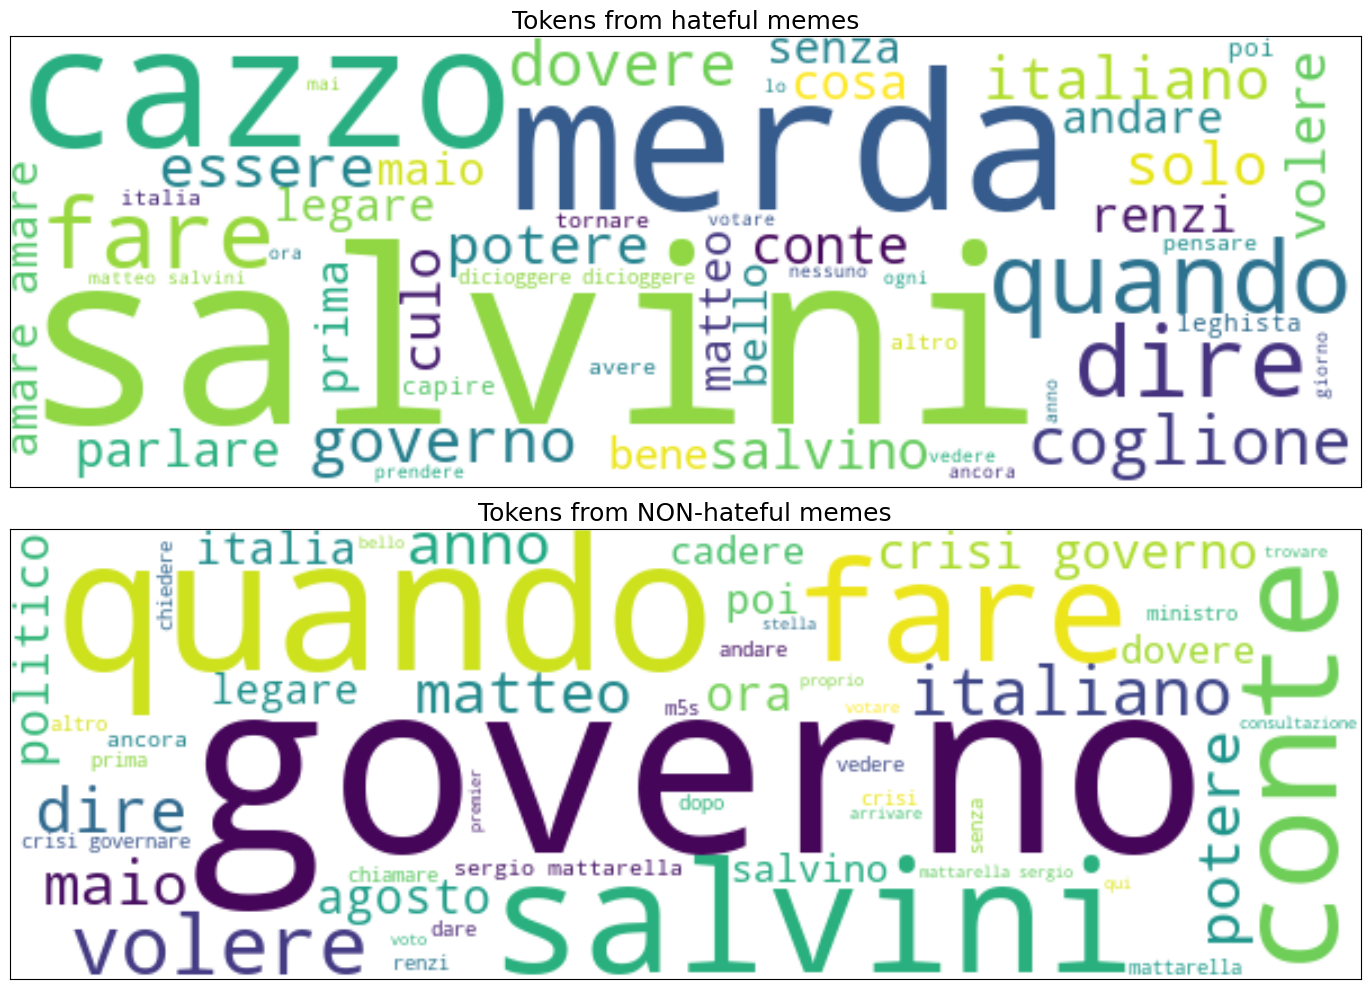

In [14]:
hateful_meme_tokens = data[data['Hate Speech']==1]['Tokens'].tolist()
nonhateful_meme_tokens = data[data['Hate Speech']==0]['Tokens'].tolist()
wordcloud_hate = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(hateful_meme_tokens))
wordcloud_not_hate = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(nonhateful_meme_tokens))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.imshow(wordcloud_hate, interpolation='bilinear')
ax2.imshow(wordcloud_not_hate, interpolation='bilinear')
ax1.set_title('Tokens from hateful memes', fontsize = 18)
ax2.set_title('Tokens from NON-hateful memes', fontsize = 18)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [15]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Prodi,-1,0,-1
Toninelli,-2,0,-2
Berlusconi,-11,10,-1
Bernini,-1,1,0
Minetti,-1,0,-1
Lega,-9,7,-2
Gentiloni,-2,1,-1
Adinolfi,-1,0,-1
Merkel,-1,0,-1
Casellati,-1,0,-1


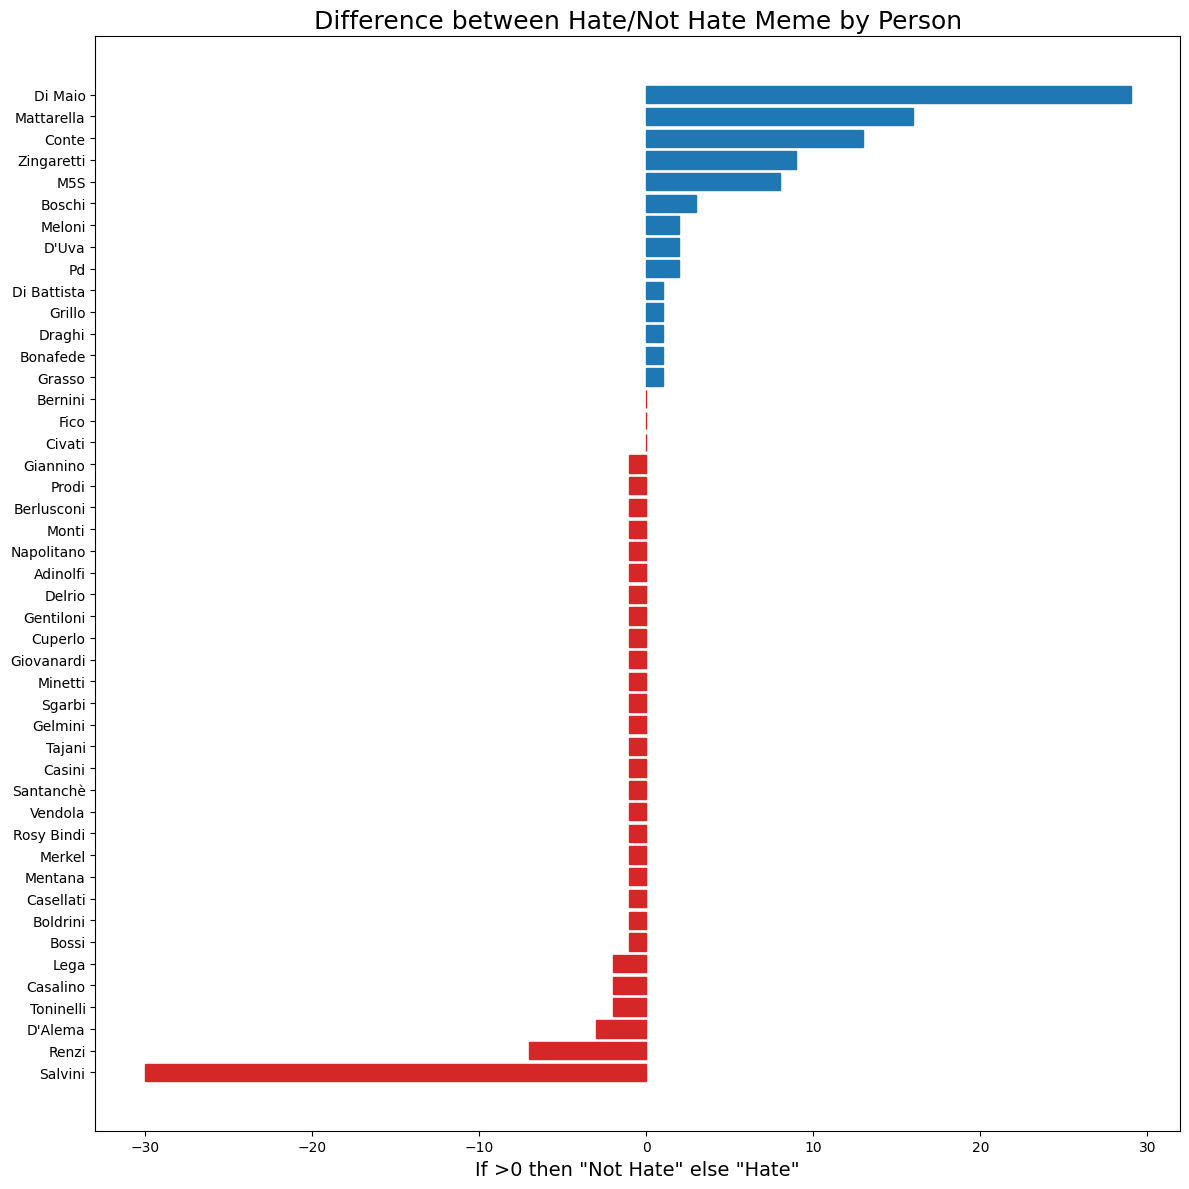

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [17]:
# The hate score is given by the difference between the number of
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
617,1617.jpg,31,0,Mattarella,16.0,aiuto.,aiuto,0
20,1020.jpg,61,1,Mattarella,16.0,quando non vuoi tornare alle urne e nessun par...,quando volere tornare urna nessuno partito riu...,0
676,1676.jpg,69,0,Salvini,-30.0,"""scusi, lei spaccia?"" ""a spaccimm e chitemmuort!""",scusire spacciare spaccimm chitemmuort,1
142,1142.jpg,8,1,Salvini,-30.0,maalox,maalox,0
320,1320.jpg,4,0,"Conte, Salvini",-17.0,"da questo momento in avanti, sulla carta igien...",momento avanti carta igienico fabbricato nobil...,1
165,1165.jpg,2132,0,0,NaN,"si torna alle erezioni! il governo cade, tu no.",tornare erezione governo cadere,0
270,1270.jpg,6915,0,Conte,13.0,"""ma ti prego, se non ti dispiace, per amore de...",pregare dispiacere amore povero vecchio papà t...,0
751,1751.jpg,115,0,"Salvini, Conte, Di Maio",12.0,cerco un compagno che non mi dia buca per la p...,cercare compagno dare buca prossimo uscita rif...,0
765,1765.jpg,20,0,"Salvini, Renzi",-37.0,i dei mattei. ok ragazzi vi riporto a casa!!,mattei ragazzo riportare casa,1
491,1491.jpg,52,0,0,NaN,di maio. conte. salvini. conferenza stampa,maio conte salvini conferenza stampa,1


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [18]:
data['Nr Words Text'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Hate Speech
529,1529.jpg,6814,0,0,NaN,piuttosto che diventare un (fascista) ministro...,piuttosto diventare fascista ministro interno ...,19,1
755,1755.jpg,3,0,0,NaN,aumento iva 2020 italia close-up,aumento iva 2020 italia close,5,0
599,1599.jpg,6775,1,Di Maio,29.0,"<< caro vescovo di roma, caro gregorio ix, pro...",caro vescovo roma caro gregorio promuovire sco...,43,0
477,1477.jpg,1065,1,D'Alema,-3.0,oh hey john! speak of the devil! did somebody ...,hey john speak the devil did somebody speak ma...,28,1
255,1255.jpg,735,1,M5S,8.0,affogare i bambini in mare con la lega fare l'...,affogare bambino mare legare fare elettroshock...,16,0
29,1029.jpg,0,0,0,NaN,santanché soddisfatta che la sfiducia a conte ...,santanché soddisfatto sfiducia conte agenda ag...,20,0
622,1622.jpg,39,1,0,NaN,"giuseppi! come here, giuseppi!",giuseppo here giuseppo,4,0
609,1609.jpg,105,0,0,NaN,oggi parleremo di come matteo salvini si è inc...,oggi parlare matteo salvini inculare solo medi...,19,1
739,1739.jpg,23,0,0,NaN,"si chiama gabinetto, è pieno di stronzi.. ma n...",chiamare gabinere pieno stronze modo tirare sc...,15,1
169,1169.jpg,125,0,Salvini,-30.0,quando c'era lui,quando,3,0


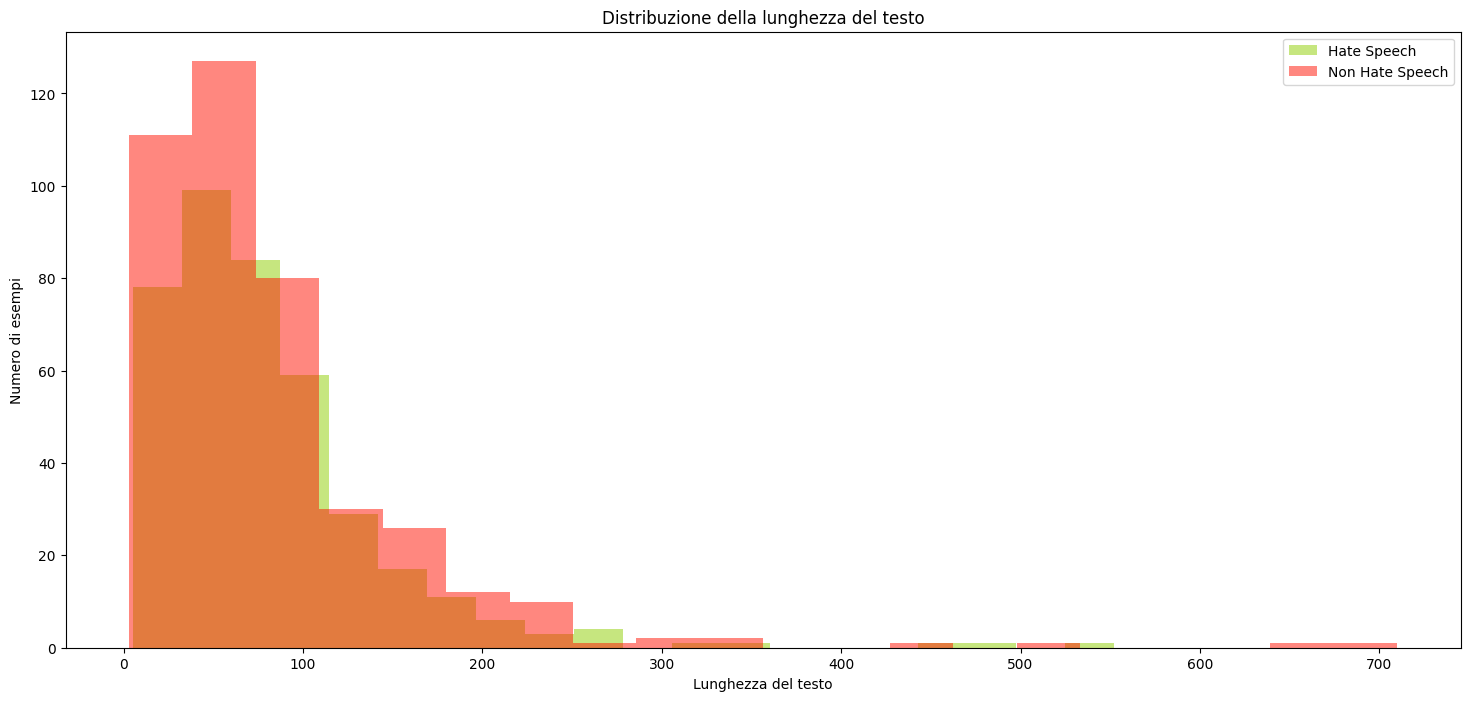

In [19]:
# Visualizzo la lunghezza del testo dei meme e delle immagini che non sono meme
# Filtra il dataset per i valori con meme = 1
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]

# Calcola la lunghezza del testo per i valori con meme = 1
meme_dataset['Nr Words Text'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words Text'] = non_meme_dataset['Text'].apply(len)

# Crea il plot della lunghezza del testo per meme e non meme
plt.hist(meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Numero di esempi')
plt.title('Distribuzione della lunghezza del testo')
plt.legend()
plt.show()

## **NER**

In [20]:
tokens = data['Tokens']
df4 = pd.DataFrame(columns=['File Id','Entity Name','Entity Label'])
for t in tokens:
    spacy_tokens = nlp(t)
    if spacy_tokens.ents:
        names = []
        labels = []
        for ent in spacy_tokens.ents:
            names.append(ent.text)
            labels.append(ent.label_)
        list_row = [data[data['Tokens'] == t]['File'].iat[0], ', '.join(names), ', '.join(labels)]
        df4.loc[len(df4)] = list_row

df4.sample(n=10)

,File Id,Entity Name,Entity Label
273,1562.jpg,boris johnson,PER
288,1591.jpg,risveglierai,LOC
66,1130.jpg,"roma, zingarettiano","LOC, LOC"
374,1774.jpg,"breaking, piero angela, alberto angela alessan...","ORG, PER, PER"
337,1704.jpg,"nero inferiore bianco, matteo salvini, mario a...","MISC, PER, PER, PER"
60,1121.jpg,pisa,LOC
140,1288.jpg,salvini vaffanculo,PER
317,1646.jpg,maio,PER
379,1788.jpg,pornhub livecams scopare adesso live sex premium,MISC
254,1515.jpg,minchia querelo,PER


## **Words Embedding**

### **Doc2Vec**

In [21]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=400, window=2, min_count=1)
d2v.build_vocab(documents)

In [24]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Doc2Vec', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Doc2Vec,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,"[-0.00097464974, -0.00074179843, 0.001051891, ...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,"[0.0006489578, -0.0010824136, -0.0010689284, 7...",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,"[-0.00046960375, 0.00029112323, 4.187107e-05, ...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,"[0.00039386586, -0.00037223025, -0.0012103562,...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,"[0.00094962236, 0.00031582013, 0.00077216135, ...",0


### **TfIdf**

In [23]:
# Tokenizzazione dei testi
documents_tfidf = [text.split() for text in data['Text']]

# Creazione del dizionario dei token
dictionary = Dictionary(documents_tfidf)

# Creazione del corpus
corpus_tfidf = [dictionary.doc2bow(doc) for doc in documents_tfidf]

# Calcolo della rappresentazione TF-IDF
tfidf = TfidfModel(corpus_tfidf)

In [38]:
data['TfIdf'] = [ tfidf[t] for t in corpus_tfidf ]
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Doc2Vec', 'TfIdf', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Doc2Vec,TfIdf,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,"[-0.00097464974, -0.00074179843, 0.001051891, ...","[(0, 0.323982732233108), (1, 0.323982732233108...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,"[0.0006489578, -0.0010824136, -0.0010689284, 7...","[(13, 0.16049350282905558), (14, 0.20003469684...",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,"[-0.00046960375, 0.00029112323, 4.187107e-05, ...","[(15, 0.04950811687373344), (27, 0.27774114363...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,"[0.00039386586, -0.00037223025, -0.0012103562,...","[(15, 0.06536980888360312), (43, 0.30645430625...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,"[0.00094962236, 0.00031582013, 0.00077216135, ...","[(15, 0.03886868566702598), (16, 0.10707188329...",0


### **BERT**

In [34]:
# Caricamento del modello preaddestrato BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
token_embeddings = []
for text in data['Text']:
    # Tokenizzazione del testo
    tokens = tokenizer.tokenize(text)

    # Aggiunta dei token [CLS] e [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Conversione dei token in ID
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Creazione del tensore di input
    input_tensor = torch.tensor([input_ids])

    # Esecuzione del modello BERT
    with torch.no_grad():
        outputs = model(input_tensor)

    # Estrazione delle rappresentazioni vettoriali dei token
    token_embedding = outputs.last_hidden_state.squeeze(0)

    token_embeddings.append(token_embedding)

In [39]:
data['BERT'] = token_embeddings
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Doc2Vec', 'TfIdf', 'BERT', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Doc2Vec,TfIdf,BERT,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,15,"[-0.00097464974, -0.00074179843, 0.001051891, ...","[(0, 0.323982732233108), (1, 0.323982732233108...","[[tensor(-0.5229), tensor(-0.0531), tensor(0.1...",1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,14,"[0.0006489578, -0.0010824136, -0.0010689284, 7...","[(13, 0.16049350282905558), (14, 0.20003469684...","[[tensor(-0.5242), tensor(-0.1135), tensor(-0....",0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,17,"[-0.00046960375, 0.00029112323, 4.187107e-05, ...","[(15, 0.04950811687373344), (27, 0.27774114363...","[[tensor(-0.6023), tensor(0.3418), tensor(-0.0...",1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,9,"[0.00039386586, -0.00037223025, -0.0012103562,...","[(15, 0.06536980888360312), (43, 0.30645430625...","[[tensor(-0.3404), tensor(-0.1730), tensor(0.2...",1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,26,"[0.00094962236, 0.00031582013, 0.00077216135, ...","[(15, 0.03886868566702598), (16, 0.10707188329...","[[tensor(-0.8017), tensor(-0.8607), tensor(0.0...",0


## MinMaxScaling

In [ ]:
scaler = MinMaxScaler()

data['Engagement'] = scaler.fit_transform(data['Engagement'].values.reshape(-1, 1))
data['Nr Words Text'] = scaler.fit_transform(data['Nr Words Text'].values.reshape(-1, 1))

# replace Nan values with 0
data['Hate Score'] = data['Hate Score'].fillna(0)
data['Hate Score'] = scaler.fit_transform(data['Hate Score'].values.reshape(-1, 1))
data.head()

# **4) MODELS DEFINITION**

---


## Words model

In [88]:
myCustomDataset = DatasetDict({
    'train': load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[:640]'),
    'eval':  load_dataset('csv', data_files=(BASE_PATHS[1] + FILENAMES[1]), split='train[640:]'),
    'test':  load_dataset('csv', data_files=(BASE_PATHS[4] + FILENAMES[14]), split='train[:]')
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


Found cached dataset csv (/Users/albertogvalerio/.cache/huggingface/datasets/csv/default-b4b0aa8d7fa28b57/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/albertogvalerio/.cache/huggingface/datasets/csv/default-27d1b7e2c5d74982/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


In [89]:
def tokenize_function(instances):
    return tokenizer(instances["Text"], padding="max_length", truncation=True)

In [91]:
def training_network(model, X_train, X_eval, y_train, y_eval, epochs, pt_save_directory=None, verbose=True):

    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    num_training_steps = epochs * len(X_train)
    num_validation_steps = epochs * len(X_eval)
    scores = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for e in tqdm(range(epochs)):
        model.train()
        trainLosses = 0
        evalLosses = 0
        trainPred = []
        evalPred = []

        for batch in X_train:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            trainLosses += loss
            predictions = torch.argmax(outputs.logits, dim=-1)
            trainPred += predictions.detach().cpu().numpy().tolist()

        with torch.no_grad():
            model.eval()
            for batch in X_eval:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                evalLosses += outputs.loss
                predictions = torch.argmax(outputs.logits, dim=-1)
                evalPred += predictions.detach().cpu().numpy().tolist()

        avgTrainLoss = trainLosses / num_training_steps
        avgValLoss = evalLosses / num_validation_steps
        scores['train_loss'].append(avgTrainLoss.detach().cpu().numpy())
        scores['val_loss'].append(avgValLoss.detach().cpu().numpy())
        scores['train_acc'].append(accuracy_score(trainPred, y_train))
        scores['val_acc'].append(accuracy_score(evalPred, y_eval))

        if verbose is True:
            print("EPOCH: {}/{} | Train loss: {:.5f}, Eval loss: {:.5f}, Train Acc: {:.5f}, Eval Acc: {:.5f}".format(
                e + 1,
                epochs,
                avgTrainLoss,
                avgValLoss,
                accuracy_score(trainPred, y_train),
                accuracy_score(evalPred, y_eval)
            ))

    if pt_save_directory is not None:
        tokenizer.save_pretrained(pt_save_directory)
        model.save_pretrained(pt_save_directory)
        
    return scores

In [92]:
def testing_network(model, X_test):
    metric_accuracy = evaluate.load('accuracy')
    metric_precision = evaluate.load('precision')
    metric_f1 = evaluate.load('f1')
    metric_recall = evaluate.load('recall')

    model.eval()
    for batch in X_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric_accuracy.add_batch(predictions=predictions, references=batch['labels'])
        metric_precision.add_batch(predictions=predictions, references=batch['labels'])
        metric_f1.add_batch(predictions=predictions, references=batch['labels'])
        metric_recall.add_batch(predictions=predictions, references=batch['labels'])

    metrics = {
        'accuracy': metric_accuracy.compute()['accuracy'],
        'precision': metric_precision.compute()['precision'],
        'f1': metric_f1.compute()['f1'],
        'recall': metric_recall.compute()['recall']
    }
    return metrics

In [93]:
def plot_training_scores(scores):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    ax1.plot(scores['train_loss'], label='training_loss')
    ax1.plot(scores['val_loss'], label='validation_loss')
    ax1.set_title('Loss Trend', fontsize = 18)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(loc='lower left')
    ax2.plot(scores['train_acc'], label='training_accuracy')
    ax2.plot(scores['val_acc'], label='validation_accuracy')
    ax2.set_title('Accuracy Trend', fontsize = 18)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

### BERT Italian

In [94]:
tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [95]:
model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment", num_labels=2, ignore_mismatched_sizes=True).to(device)
pt_save_directory = './saved_models/bert_ita'
scores1 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuraly/bert-base-italian-cased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.10528, Eval loss: 0.13889, Train Acc: 0.52031, Eval Acc: 0.68125
EPOCH: 2/5 | Train loss: 0.04523, Eval loss: 0.12182, Train Acc: 0.51875, Eval Acc: 0.76875
EPOCH: 3/5 | Train loss: 0.01968, Eval loss: 0.15581, Train Acc: 0.54063, Eval Acc: 0.76250
EPOCH: 4/5 | Train loss: 0.00614, Eval loss: 0.20880, Train Acc: 0.51406, Eval Acc: 0.76250
EPOCH: 5/5 | Train loss: 0.00346, Eval loss: 0.29721, Train Acc: 0.50156, Eval Acc: 0.67500


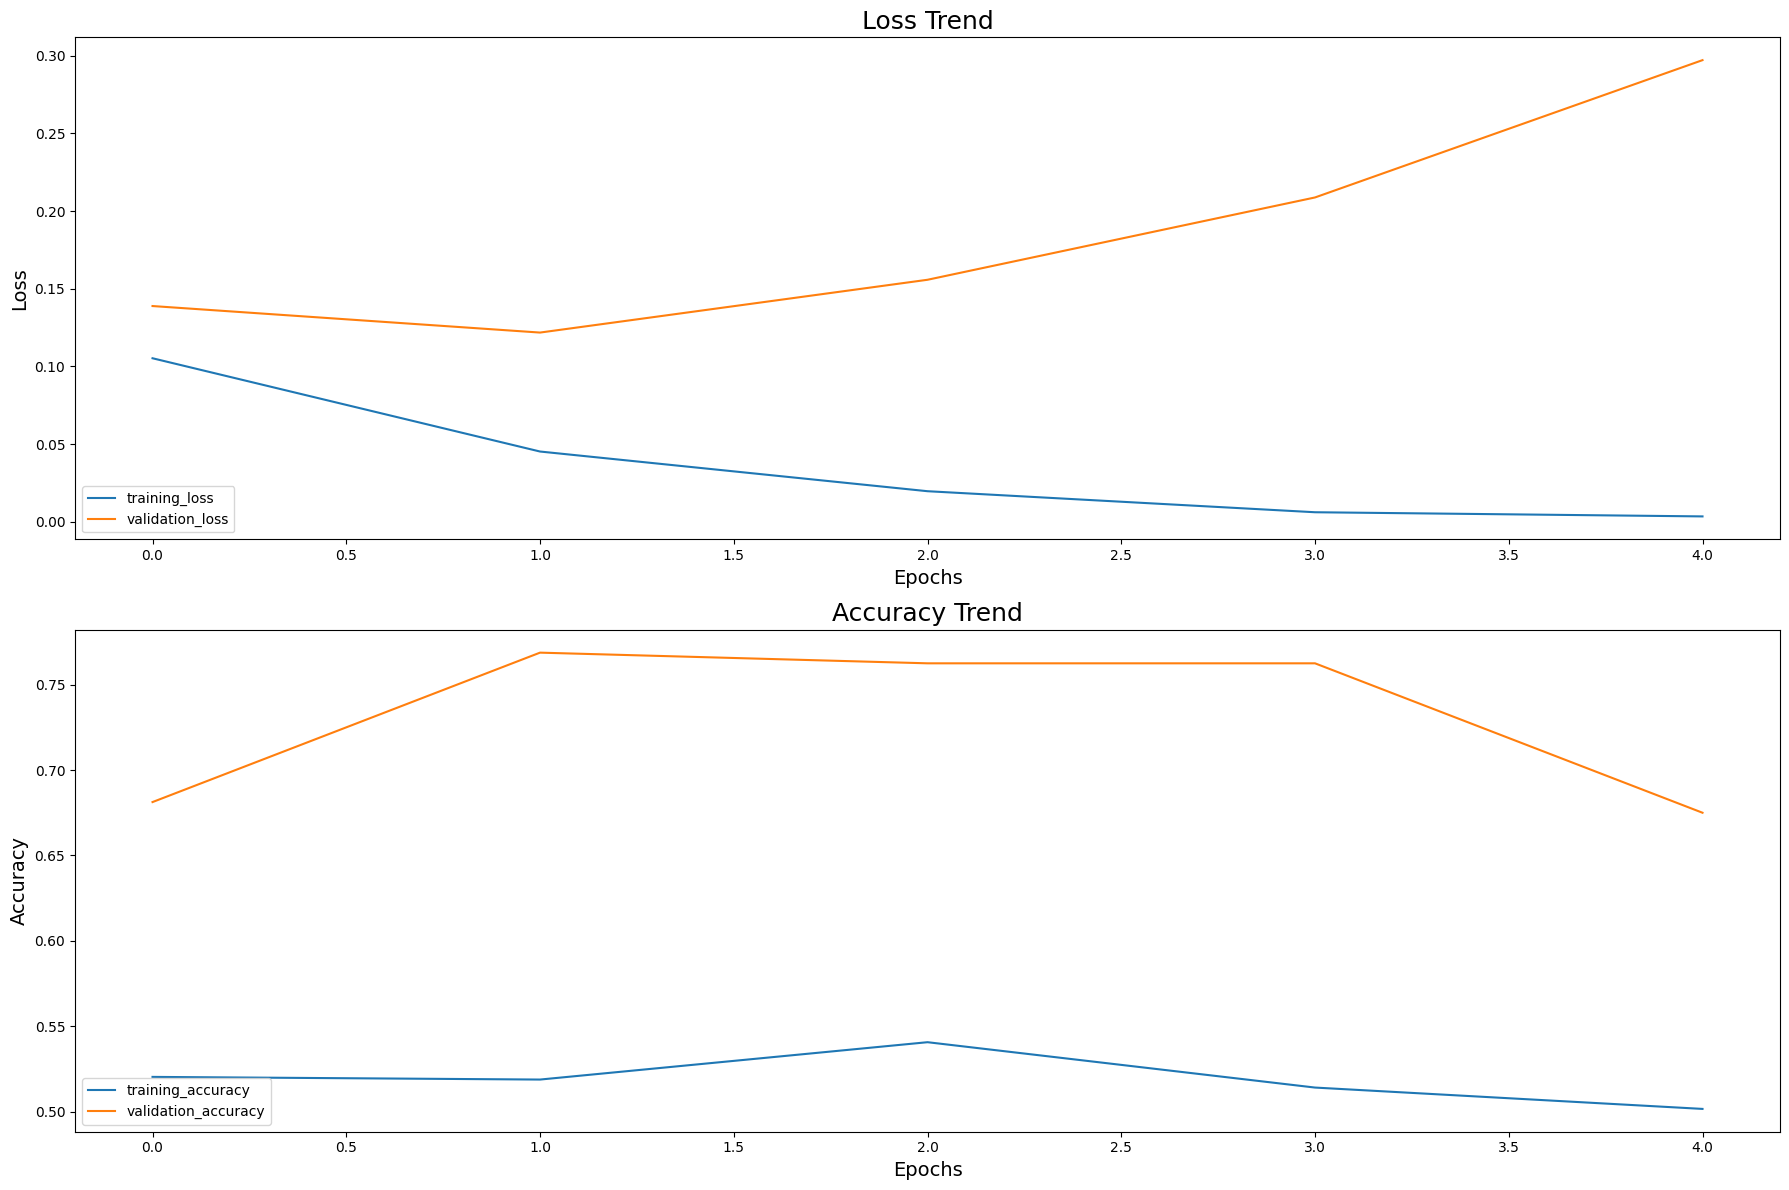

In [96]:
plot_training_scores(scores1)

In [97]:
pt_save_directory = './saved_models/bert_ita'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
metrics1 = testing_network(saved_model, test_dataloader)
for i in metrics1:
    print(f'{i.upper():>10}: {metrics1[i]:.4f}')

  ACCURACY: 0.7400
 PRECISION: 0.6963
        F1: 0.7833
    RECALL: 0.8952


### UMBERTO

In [98]:
tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [99]:
model = AutoModelForSequenceClassification.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", num_labels=2).to(device)
pt_save_directory = './saved_models/umberto'
scores2 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13716, Eval loss: 0.12392, Train Acc: 0.48125, Eval Acc: 0.65625
EPOCH: 2/5 | Train loss: 0.10583, Eval loss: 0.09512, Train Acc: 0.46250, Eval Acc: 0.77500
EPOCH: 3/5 | Train loss: 0.06915, Eval loss: 0.09198, Train Acc: 0.50000, Eval Acc: 0.79375
EPOCH: 4/5 | Train loss: 0.03885, Eval loss: 0.14135, Train Acc: 0.49375, Eval Acc: 0.75000
EPOCH: 5/5 | Train loss: 0.03780, Eval loss: 0.09994, Train Acc: 0.50313, Eval Acc: 0.85625


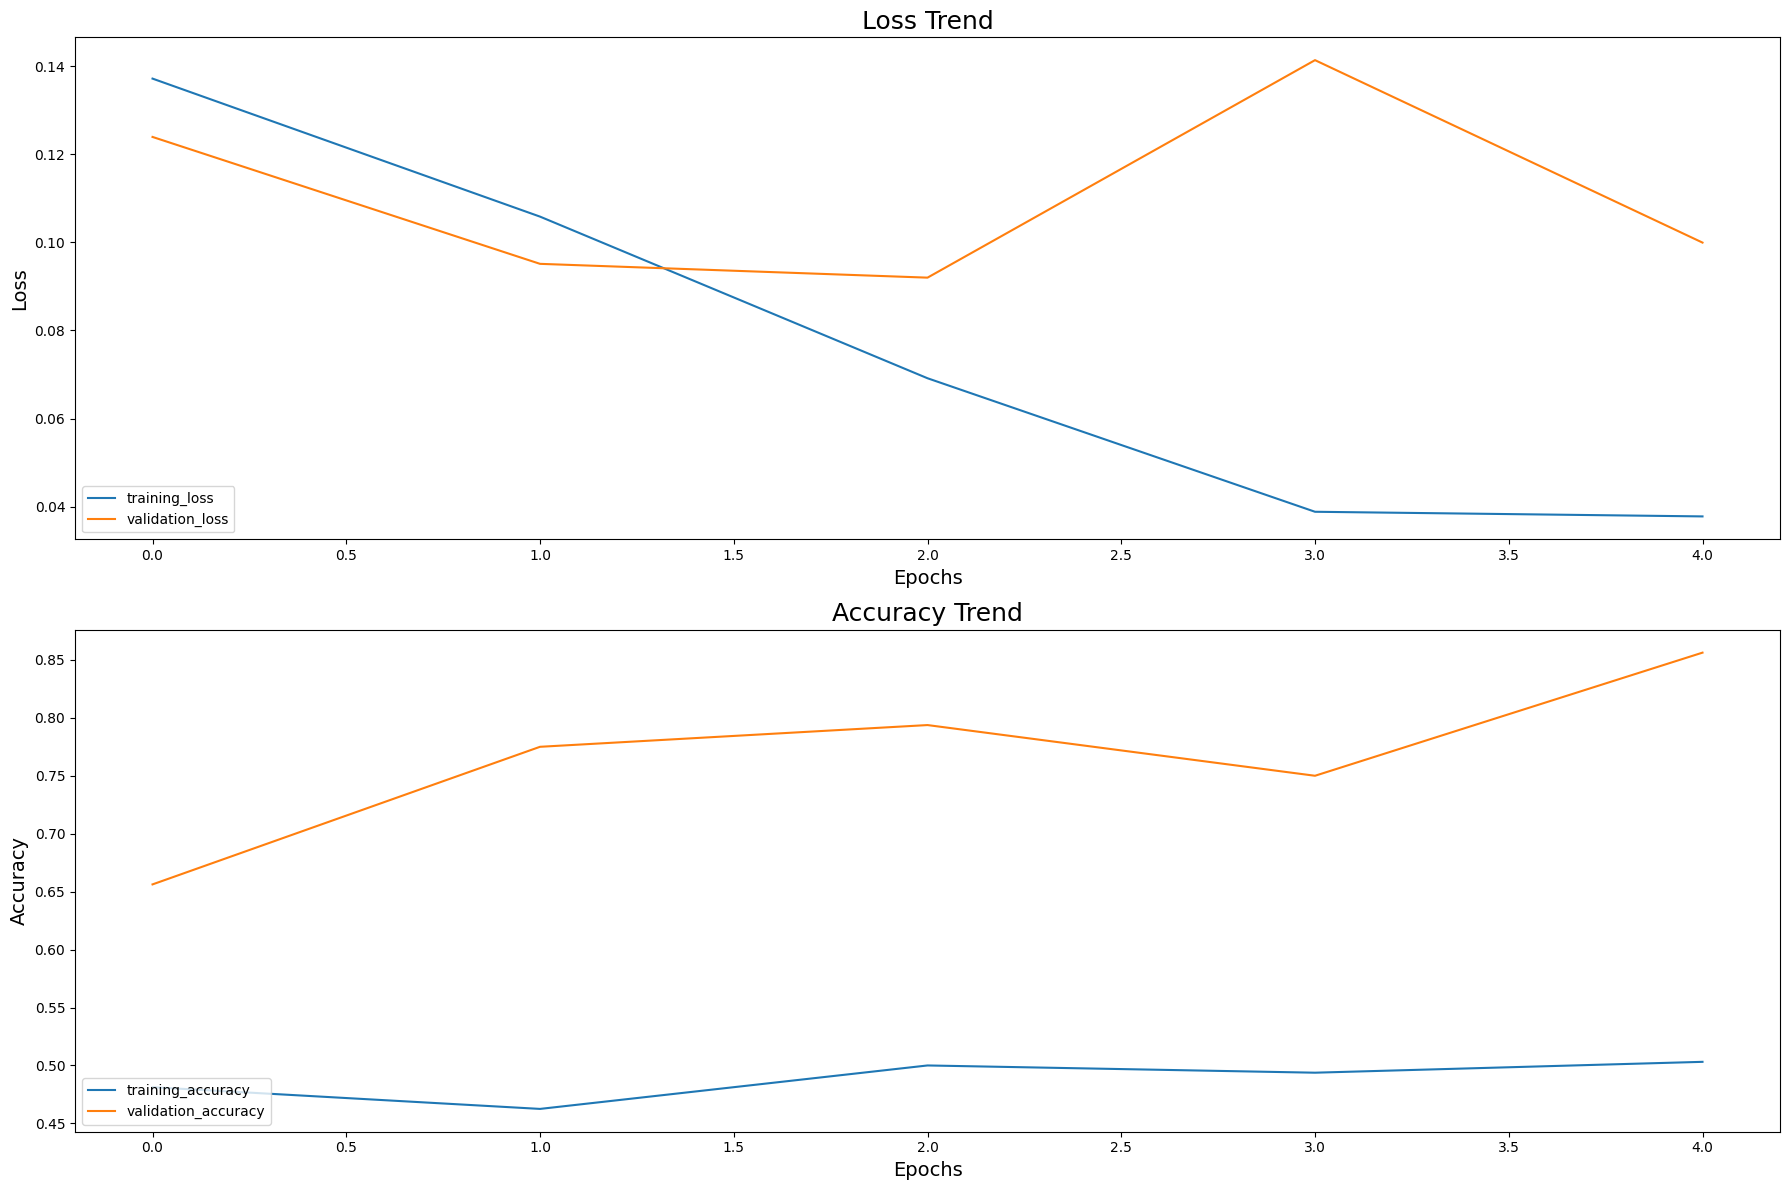

In [100]:
plot_training_scores(scores2)

In [101]:
pt_save_directory = './saved_models/umberto'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
metrics2 = testing_network(saved_model, test_dataloader)
for i in metrics2:
    print(f'{i.upper():>10}: {metrics2[i]:.4f}')

  ACCURACY: 0.8250
 PRECISION: 0.9070
        F1: 0.8168
    RECALL: 0.7429


### FEEL-IT

In [102]:
tokenizer = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-emotion", model_max_length=512)

tokenized_datasets = myCustomDataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['File', 'Engagement', 'Manipulation', 'Visual', 'Text'])
tokenized_datasets = tokenized_datasets.rename_column('Hate Speech', 'labels')
tokenized_datasets.set_format("torch")

print(tokenized_datasets)

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

Map:   0%|          | 0/640 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 640
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 160
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})


In [103]:
model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-emotion", num_labels=2, ignore_mismatched_sizes=True).to(device)
pt_save_directory = './saved_models/feel_it'
scores3 = training_network(model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at MilaNLProc/feel-it-italian-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.12265, Eval loss: 0.10856, Train Acc: 0.51875, Eval Acc: 0.72500
EPOCH: 2/5 | Train loss: 0.09179, Eval loss: 0.10794, Train Acc: 0.49844, Eval Acc: 0.75625
EPOCH: 3/5 | Train loss: 0.06061, Eval loss: 0.12382, Train Acc: 0.50625, Eval Acc: 0.71250
EPOCH: 4/5 | Train loss: 0.03729, Eval loss: 0.13534, Train Acc: 0.46719, Eval Acc: 0.75625
EPOCH: 5/5 | Train loss: 0.02663, Eval loss: 0.15964, Train Acc: 0.48594, Eval Acc: 0.69375


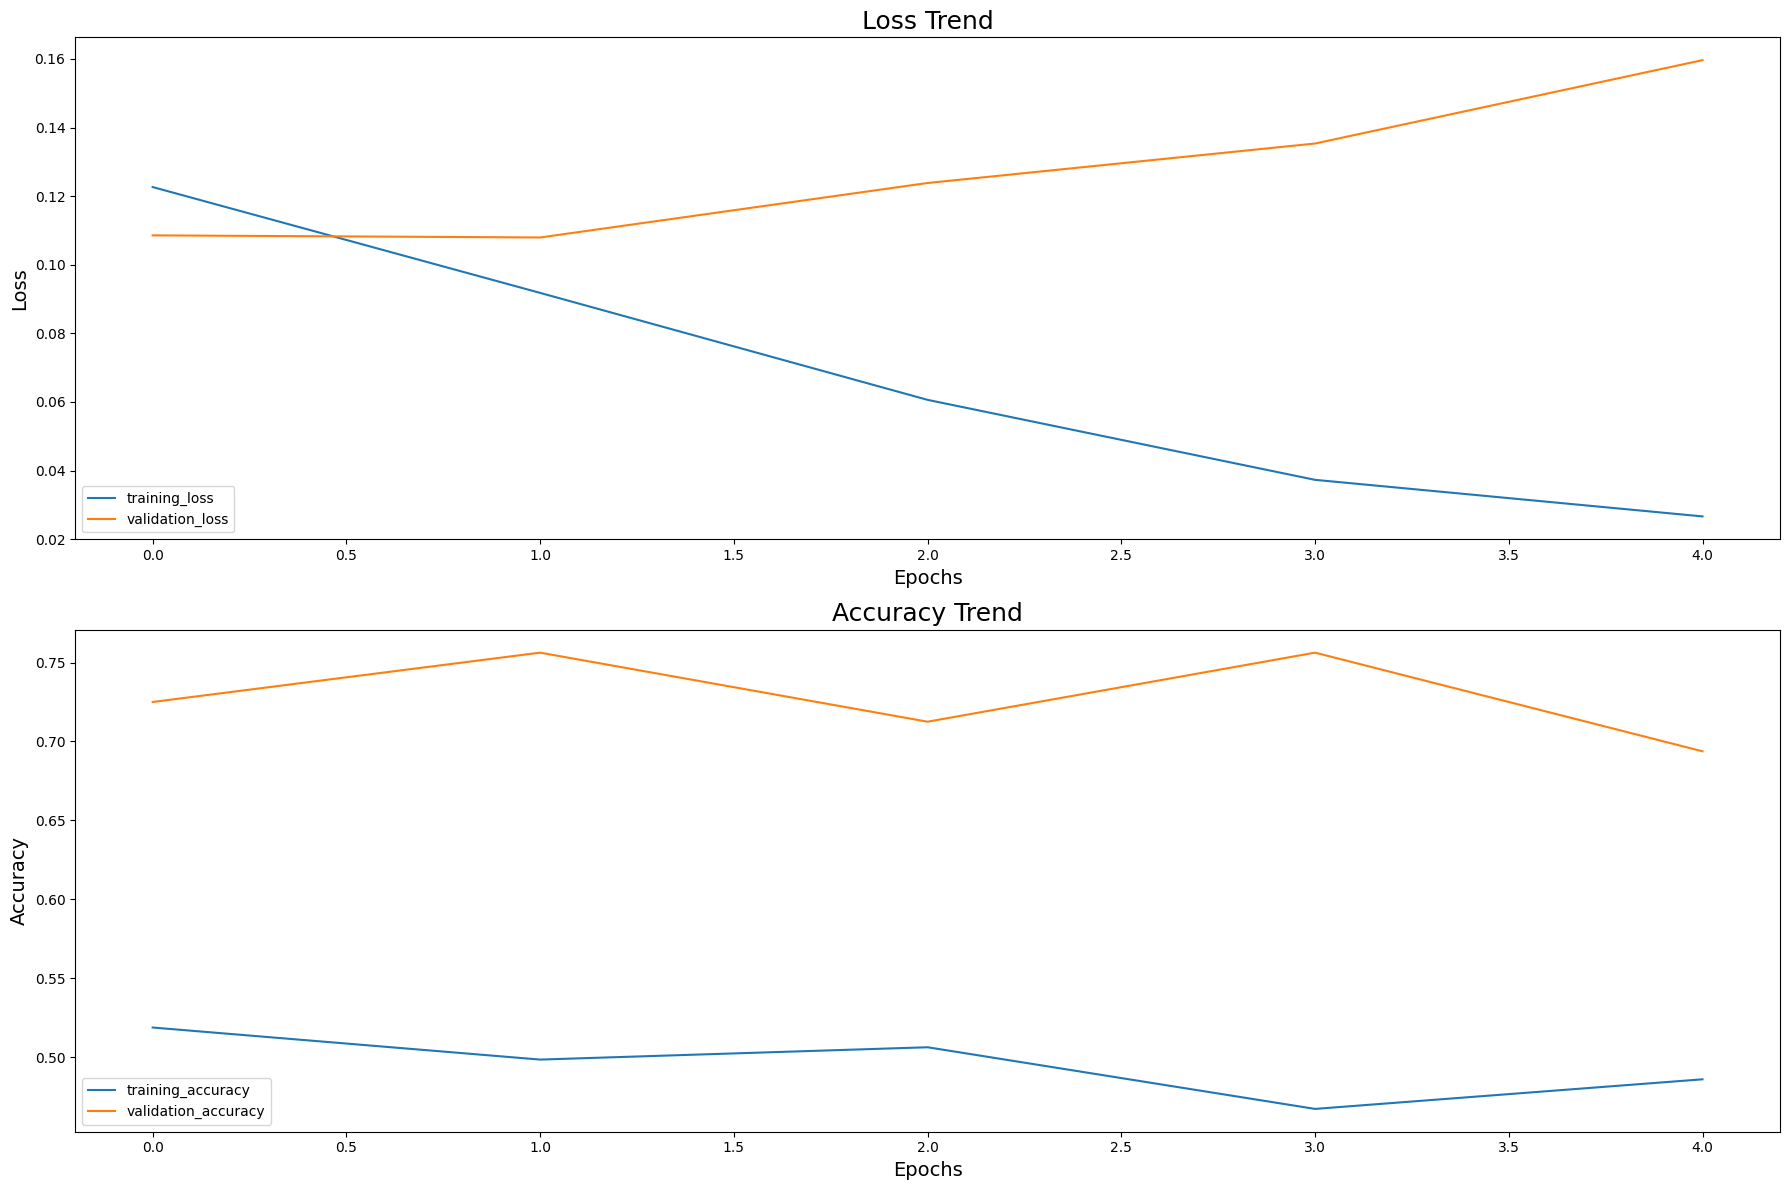

In [104]:
plot_training_scores(scores3)

In [105]:
pt_save_directory = './saved_models/feel_it'
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
metrics3 = testing_network(saved_model, test_dataloader)
for i in metrics3:
    print(f'{i.upper():>10}: {metrics3[i]:.4f}')

  ACCURACY: 0.7400
 PRECISION: 0.9649
        F1: 0.6790
    RECALL: 0.5238


### Models comparison

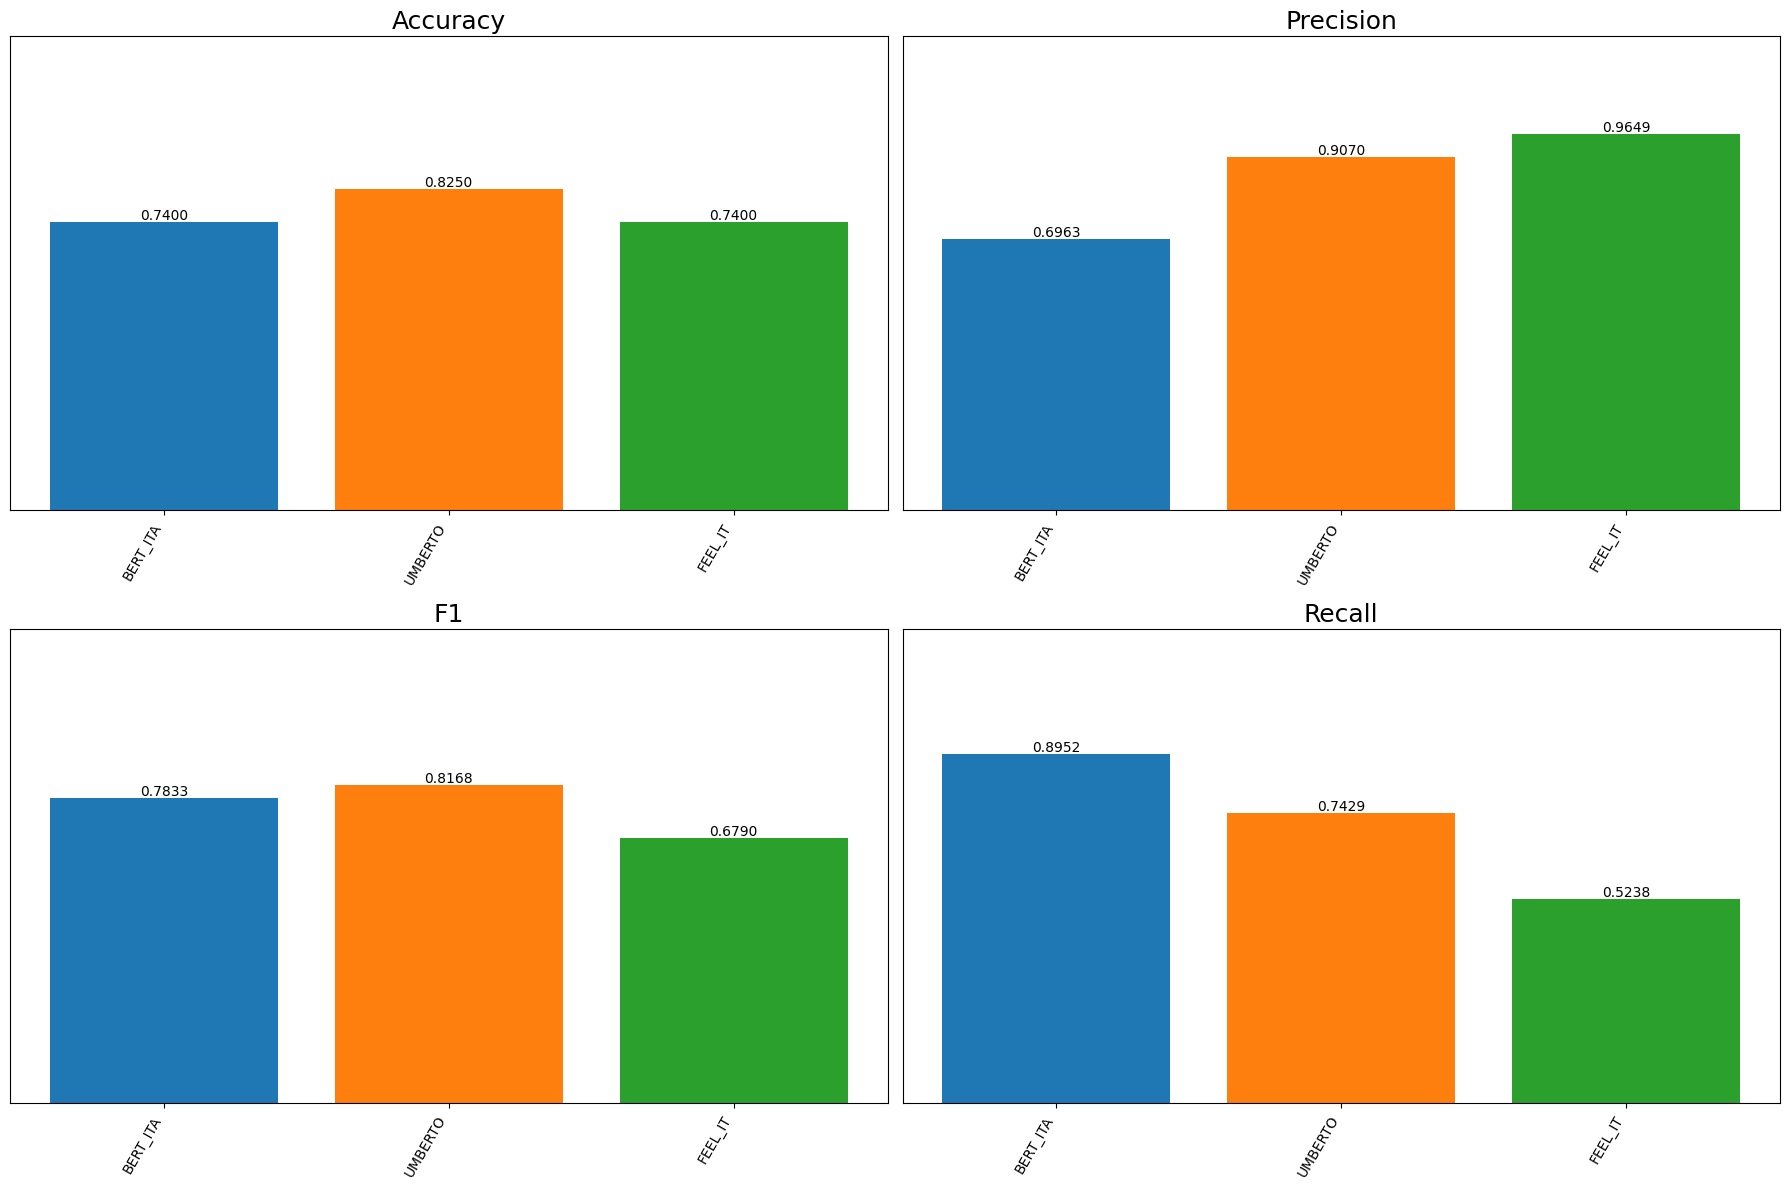

In [106]:
height1 = [metrics1['accuracy'],  metrics2['accuracy'],  metrics3['accuracy']]
height2 = [metrics1['precision'], metrics2['precision'], metrics3['precision']]
height3 = [metrics1['f1'],        metrics2['f1'],        metrics3['f1']]
height4 = [metrics1['recall'],    metrics2['recall'],    metrics3['recall']]
labels = ['BERT_ITA', 'UMBERTO', 'FEEL_IT']

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels, height=height1, color=colors)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars2 = ax2.bar(labels, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars3 = ax3.bar(labels, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars4 = ax4.bar(labels, height=height4, color=colors)
for rect in bars4:
     height = rect.get_height()
     ax4.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.set_title('Accuracy', fontsize = 18)
ax2.set_title('Precision', fontsize = 18)
ax3.set_title('F1', fontsize = 18)
ax4.set_title('Recall', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax2.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax3.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax4.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax1.set_xticklabels(labels, rotation = 60, ha="right")
ax2.set_xticklabels(labels, rotation = 60, ha="right")
ax3.set_xticklabels(labels, rotation = 60, ha="right")
ax4.set_xticklabels(labels, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

## Images model

In [17]:
embeddings_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[4], header=None)
embeddings_train['Train Embeddings'] = [np.array(i.split()).astype(np.float32) for i in embeddings_train.loc[:][1]]
embeddings_train['Labels'] = data['Hate Speech']
embeddings_train = embeddings_train[['Train Embeddings','Labels']]
embeddings_train.head()

,Train Embeddings,Labels
0,"[0.03371752, 0.71383077, 0.1622142, 0.15153012...",1
1,"[0.017445266, 0.01675424, 0.06025219, 0.088076...",0
2,"[0.2331691, 2.1796272, 0.0, 0.004503002, 1.169...",1
3,"[0.09365508, 1.8714182, 0.5247863, 0.039612748...",1
4,"[0.12720379, 1.260958, 0.1069836, 0.27789292, ...",0


In [18]:
embeddings_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[10], header=None)
embeddings_test['Test Embeddings'] = [np.array(i.split()).astype(np.float32) for i in embeddings_test.loc[:][1]]
goldData = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
embeddings_test['Labels'] = goldData['Hate Speech']
embeddings_test = embeddings_test[['Test Embeddings', 'Labels']]
embeddings_test.head()

,Test Embeddings,Labels
0,"[0.27691776, 0.952373, 0.06241767, 0.58647937,...",1
1,"[0.07759489, 1.8289204, 1.7770578, 0.07402565,...",0
2,"[0.28806925, 1.3223957, 0.07227258, 0.24837093...",1
3,"[0.3849284, 0.94429594, 0.8429149, 0.53647035,...",0
4,"[0.06668279, 0.85113406, 0.40766233, 0.3558357...",1


In [58]:
class MyCustomDataset(TorchDataset):
	def __init__(self, embeddings, labels):
		self.embeddings = embeddings
		self.labels = labels
	def __len__(self):
		return len(self.embeddings)
	def __getitem__(self, idx):
		imageEmb = self.embeddings[idx]
		imageLab = self.labels[idx]
		#imageEmb = MinMaxScaler().fit_transform(imageEmb.reshape(-1, 1))
		imageEmb = torch.tensor(imageEmb.reshape(1, -1)).unsqueeze(0)
		imageLab = torch.tensor(imageLab, dtype=torch.float32, requires_grad=True)
		return (imageEmb, imageLab)

split = int(len(embeddings_train) * .8)
num_batch = 10

trainingDS = MyCustomDataset(
					embeddings=embeddings_train[:split]['Train Embeddings'].values,
					labels=embeddings_train[:split]['Labels'].values)
validationDS = MyCustomDataset(
					embeddings=embeddings_train[split:]['Train Embeddings'].values,
					labels=embeddings_train[split:]['Labels'].values)

trainLoader = DataLoader(trainingDS, shuffle=True, batch_size=num_batch)
valLoader = DataLoader(validationDS, shuffle=False, batch_size=num_batch)

In [67]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_fc = nn.Linear(2048, 1024)
        self.hidden_fc = nn.Linear(1024, 256)
        self.output_fc = nn.Linear(256, 2)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.tanh(self.input_fc(x))
        h_2 = F.tanh(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred

# EXPERIMENTAL PLAYGROUND

---

## First experiment

In [107]:
extra = pd.read_csv(BASE_PATHS[1] + FILENAMES[13], header=None)
extra = extra[[1,2]]
extra = extra.rename(columns={1: "Text", 2: "labels"})

hate = extra.loc[extra['labels'] == 1]
nohate = extra.loc[extra['labels'] == 0]

print(''.join(['> ' for i in range(40)]))
print(f'\n{"Tweet":<25}{"Number":<18}{"Percentage":<18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'{"HATE":<25}{len(hate):<18}{(len(hate) * 100 / len(extra)):<18.2f}')
print(f'{"NO HATE":<25}{len(nohate):<18}{(len(nohate) * 100 / len(extra)):<18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Tweet                    Number            Percentage        

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
HATE                     622               49.25             
NO HATE                  641               50.75             


In [109]:
augmented_data = pd.concat([hate, nohate])
augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)

test_data = pd.read_csv(BASE_PATHS[4] + FILENAMES[14])
test_data = test_data[['Text', 'Hate Speech']]
test_data = test_data.rename(columns={"Hate Speech": "labels"})

In [110]:
split = int(len(augmented_data) * .8)
extraData = DatasetDict({
    'train': Dataset.from_pandas(augmented_data.iloc[:split]),
    'eval': Dataset.from_pandas(augmented_data.iloc[split:]),
    'test':  Dataset.from_pandas(test_data)
})

In [111]:
pt_save_directory = './saved_models/bert_ita'
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = './saved_models/bert_ita/after'
scores4 = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.12793, Eval loss: 0.09794, Train Acc: 0.49505, Eval Acc: 0.79051
EPOCH: 2/5 | Train loss: 0.07690, Eval loss: 0.11853, Train Acc: 0.50792, Eval Acc: 0.74704
EPOCH: 3/5 | Train loss: 0.04579, Eval loss: 0.09427, Train Acc: 0.49208, Eval Acc: 0.80632
EPOCH: 4/5 | Train loss: 0.01468, Eval loss: 0.16913, Train Acc: 0.49307, Eval Acc: 0.73913
EPOCH: 5/5 | Train loss: 0.00932, Eval loss: 0.21752, Train Acc: 0.49802, Eval Acc: 0.75494


In [112]:
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
metrics4 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Bert_Ita":<18}{"Bert_Ita++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics4:
    print(f'{i.upper():<25}{metrics1[i]:<18.4f}{metrics4[i]:<18.4f}{(metrics4[i] - metrics1[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Bert_Ita          Bert_Ita++        Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7400            0.6200            -0.1200           
PRECISION                0.6963            0.8372            0.1409            
F1                       0.7833            0.4865            -0.2968           
RECALL                   0.8952            0.3429            -0.5524           


In [113]:
pt_save_directory = './saved_models/umberto'
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = './saved_models/umberto/after'
scores4 = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.12236, Eval loss: 0.10571, Train Acc: 0.49307, Eval Acc: 0.73913
EPOCH: 2/5 | Train loss: 0.07961, Eval loss: 0.10554, Train Acc: 0.51980, Eval Acc: 0.73123
EPOCH: 3/5 | Train loss: 0.05551, Eval loss: 0.10926, Train Acc: 0.49109, Eval Acc: 0.75494
EPOCH: 4/5 | Train loss: 0.03578, Eval loss: 0.17276, Train Acc: 0.51782, Eval Acc: 0.76680
EPOCH: 5/5 | Train loss: 0.02000, Eval loss: 0.15399, Train Acc: 0.49802, Eval Acc: 0.76285


In [114]:
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
metrics5 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"Umberto":<18}{"Umberto++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics5:
    print(f'{i.upper():<25}{metrics2[i]:<18.4f}{metrics5[i]:<18.4f}{(metrics5[i] - metrics2[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   Umberto           Umberto++         Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.8250            0.6900            -0.1350           
PRECISION                0.9070            0.8308            -0.0762           
F1                       0.8168            0.6353            -0.1815           
RECALL                   0.7429            0.5143            -0.2286           


In [115]:
pt_save_directory = './saved_models/feel_it'
tokenizer = AutoTokenizer.from_pretrained(pt_save_directory, model_max_length=512)

tokenized_datasets = extraData.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets['train'], shuffle=True, batch_size=10)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=10)
test_dataloader = DataLoader(tokenized_datasets['test'])
train_labels = tokenized_datasets['train'][:]['labels']
eval_labels = tokenized_datasets['eval'][:]['labels']
num_epochs = 5

saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
pt_save_directory = './saved_models/feel_it/after'
scores4 = training_network(saved_model, train_dataloader, eval_dataloader, train_labels, eval_labels, num_epochs, pt_save_directory)

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 1/5 | Train loss: 0.13620, Eval loss: 0.10593, Train Acc: 0.49109, Eval Acc: 0.75099
EPOCH: 2/5 | Train loss: 0.09629, Eval loss: 0.11607, Train Acc: 0.49802, Eval Acc: 0.70751
EPOCH: 3/5 | Train loss: 0.05760, Eval loss: 0.13052, Train Acc: 0.53663, Eval Acc: 0.77075
EPOCH: 4/5 | Train loss: 0.03715, Eval loss: 0.18063, Train Acc: 0.49505, Eval Acc: 0.72727
EPOCH: 5/5 | Train loss: 0.03868, Eval loss: 0.12937, Train Acc: 0.51188, Eval Acc: 0.78261


In [116]:
saved_model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory).to(device)
metrics6 = testing_network(saved_model, test_dataloader)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"Metric":<25}{"FeelIt":<18}{"FeelIt++":<18}{"Gain":<18}\n')
print(''.join(['> ' for i in range(40)]))
for i in metrics6:
    print(f'{i.upper():<25}{metrics3[i]:<18.4f}{metrics6[i]:<18.4f}{(metrics6[i] - metrics3[i]):<18.4f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

Metric                   FeelIt            FeelIt++          Gain              

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
ACCURACY                 0.7400            0.6350            -0.1050           
PRECISION                0.9649            0.9000            -0.0649           
F1                       0.6790            0.4966            -0.1825           
RECALL                   0.5238            0.3429            -0.1810           


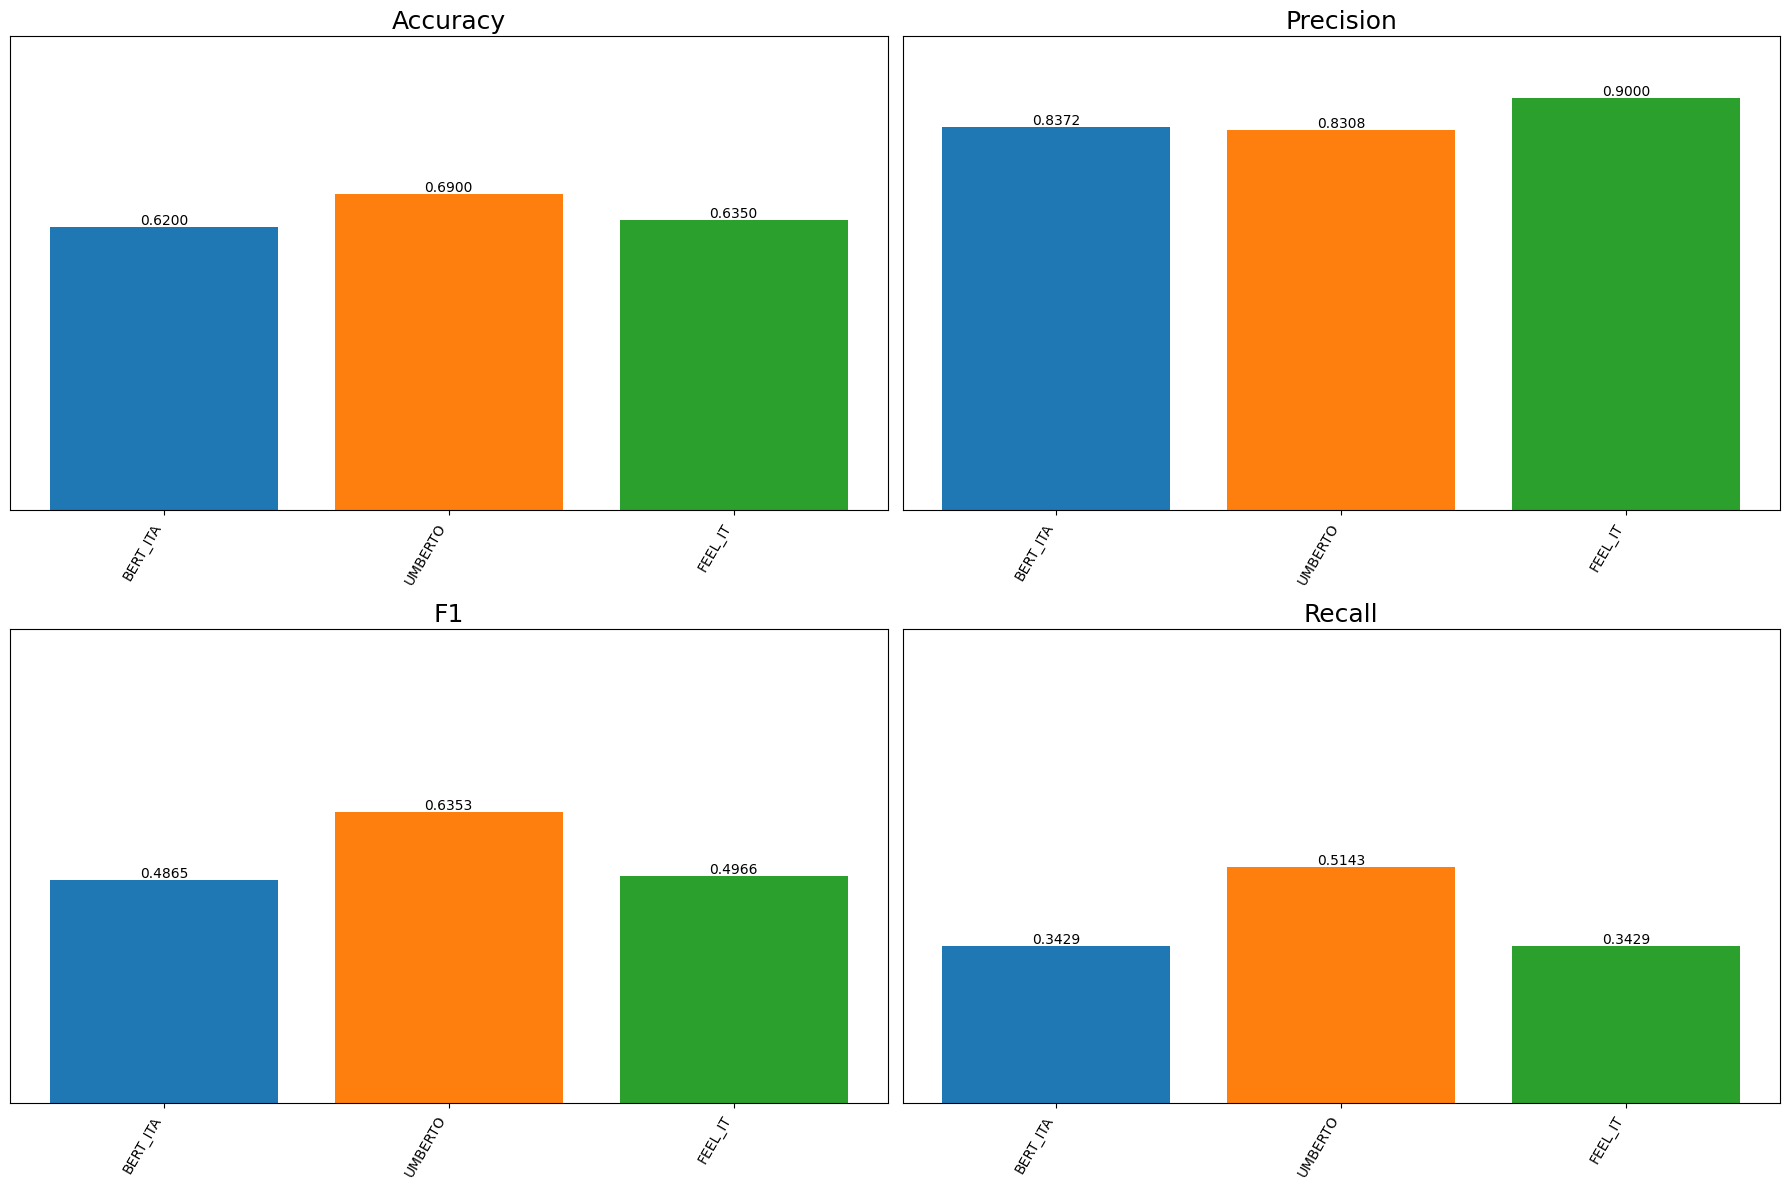

In [117]:
height1 = [metrics4['accuracy'],  metrics5['accuracy'],  metrics6['accuracy']]
height2 = [metrics4['precision'], metrics5['precision'], metrics6['precision']]
height3 = [metrics4['f1'],        metrics5['f1'],        metrics6['f1']]
height4 = [metrics4['recall'],    metrics5['recall'],    metrics6['recall']]
labels = ['BERT_ITA', 'UMBERTO', 'FEEL_IT']

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels, height=height1, color=colors)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars2 = ax2.bar(labels, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars3 = ax3.bar(labels, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')
bars4 = ax4.bar(labels, height=height4, color=colors)
for rect in bars4:
     height = rect.get_height()
     ax4.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])
ax1.set_title('Accuracy', fontsize = 18)
ax2.set_title('Precision', fontsize = 18)
ax3.set_title('F1', fontsize = 18)
ax4.set_title('Recall', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax2.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax3.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax4.set_ylim(ymin=0, ymax=(max(height3)+.4))
ax1.set_xticklabels(labels, rotation = 60, ha="right")
ax2.set_xticklabels(labels, rotation = 60, ha="right")
ax3.set_xticklabels(labels, rotation = 60, ha="right")
ax4.set_xticklabels(labels, rotation = 60, ha="right")
plt.tight_layout()
plt.show()